# Data Scientist Technical Test

Ross Guthery

2 November 2022

In [1]:
# Import packages.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from toolbox import Data, FeatureEngineerer, Modeller

# Standardize figure size.
plt.rcParams["figure.figsize"] = (10, 8)

### 1. Data Collection and Cleaning

To manage the reading in and cleaning of the data needed to complete this test, I wrote a class called ```Data```. Data collection is obviously straightforward. Data cleaning, however, isn't. The class's private ```clean_data``` function retitles the columns so they are easier to understand, drops columns I either can't use or don't understand, and removes unecessary characters like "_z", "<", "$", and ",". Furthermore, it ensures each column is the appropriate data type and replaces boolean values like "yes" and "no" with more usable ones and zeros. As an aside, it's during this step that I drop the one outlier I found, which is a negative car age. I also drop the only duplicate row I stumbled upon. (I only carry out the last two steps on the training data.)

In [2]:
# Instantiate a Data object for the test and train sets.
test_data: Data = Data(
    train=False, file_path="data/test_auto.csv", index_col=0,
)
train_data: Data = Data(
    train=True, file_path="data/train_auto.csv", index_col=0,
)

In [3]:
# Call the test and train set Data objects.
test_data()
train_data()

In [4]:
# Display where the null values are in the train set.
pd.concat(
    objs=[train_data.data.isnull().sum(), test_data.data.isnull().sum()],
    keys=['train_nulls', 'test_nulls'],
    axis=1,
)

,train_nulls,test_nulls
target_flag,0,2141
num_kids_driving,0,0
age,6,1
num_kids_home,0,0
income,413,125
is_single_parent,0,0
home_value,428,111
is_married,0,0
is_female,0,0
education,0,0


I spent a fair amount of time reflecting upon how to best manage the null values that appear in the age, job, income, car age, and home value columns of the data set. In the end, I decided to proceed as follows. First, I replaced the null values in the age and car age columns with the mean of said columns as the mean and median of each are less than one year apart. Next, I removed rows with null values in the job column as the average income earned by blue collar workers, the most common occupation, does not align with the average income earned by those whose occupation isn't listed ($59,282 vs. $118,457). Moreover, the standard deviation of the latter group's income distribution is $58,834, which essentially means that five of the eight possible occupations are within one standard deviation of the their average income. Furthermore, I also removed rows with null values in either the income or home value columns as, in my opinion, inferring a value for either could portend a gross misjudgement on our part. An income of zero could mean that someone is unemployed, just as a home value of zero could mean that someone is a renter. In other words, it would be unjust to make an assumption here. The final component of this step consisted of removing null values in the target column. (It's obvious why we don't have any data here.)

In [5]:
# Drop null values in the test and train sets according to the strategy above.
test_data.deal_with_nulls()
train_data.deal_with_nulls()

In [6]:
# Display the first five rows of the train set to visualize the cleaned data.
train_data.data.head()

,target_flag,num_kids_driving,age,num_kids_home,income,is_single_parent,home_value,is_married,is_female,education,...,travel_time,for_commercial_use,bluebook_value,car_type,is_red_car,last_claim_value,claim_frequency,was_revoked,car_age,is_urban
0,0,0,60.0,0,67349.0,0,0.0,0,0,phd,...,14,0,14230,minivan,1,4461,2,0,18.0,1
1,0,0,43.0,0,91449.0,0,257252.0,0,0,high_school,...,22,1,14940,minivan,1,0,0,0,1.0,1
2,0,0,35.0,1,16039.0,0,124191.0,1,1,high_school,...,5,0,4010,suv,0,38690,2,0,10.0,1
4,0,0,50.0,0,114986.0,0,243925.0,1,1,phd,...,36,0,18000,suv,0,19217,2,1,17.0,1
5,1,0,34.0,1,125301.0,1,0.0,0,1,bachelors,...,46,1,17430,sports_car,0,0,0,0,7.0,1


### 2. Feature Engineering

In [7]:
# Instantiate a FeatureEngineerer object for the test and train sets.
test_engineerer: FeatureEngineerer = FeatureEngineerer(data=test_data.data)
train_engineerer: FeatureEngineerer = FeatureEngineerer(data=train_data.data)

In [8]:
# Call the test and train sets FeatureEngineerer objects. This one-hot encodes
# the non-numerical categorical variables and also performs min-max scaling.
test_engineerer()
train_engineerer()

Given my background in economics, I know that one possible route to follow when engineering new features is to create interaction terms. We need to first identify the variables in the data set whose interaction is highly correlated with the target. This correlation can be either positive or negative. One way of visualizing the correlation I just described is with a heat map, and I have plotted one below. It suffices to only analyze either above or below the dark blue diagonal as the map is symmetric. Although many relationships stick out, I am going to focus on those that relate non-car characteristics to car characterisitcs given the context of the problem. These relationships are:
- Being female and having an SUV,
- Being female and having a red car, and
- Having a high school education and a car's age.

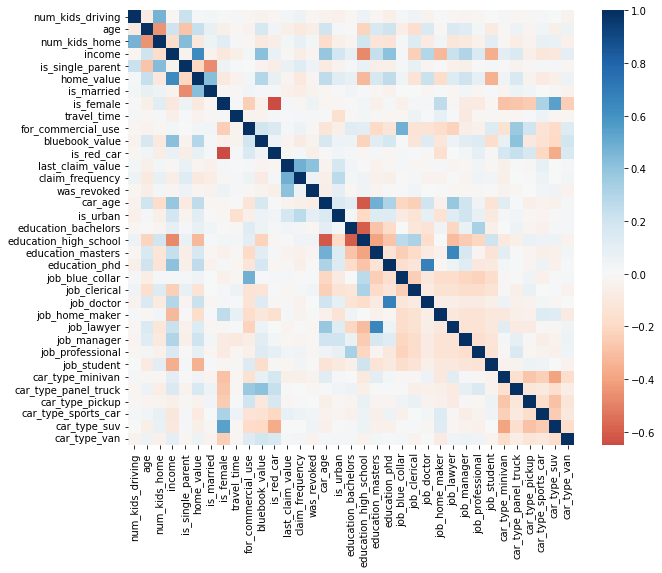

In [9]:
# Plot heat map to show correlation between explanatory variables and target.
sns.heatmap(data=test_engineerer.data.corr(), cmap="RdBu", center=0)
plt.show()

In [10]:
# Add the interaction variables mentioned above to the test and train sets.
test_engineerer.get_interaction_terms()
train_engineerer.get_interaction_terms()

In [11]:
# Display the first five rows of the train set to visualize the engineered data.
train_engineerer.data.head(5)

,target_flag,num_kids_driving,age,num_kids_home,income,is_single_parent,home_value,is_married,is_female,travel_time,...,job_student,car_type_minivan,car_type_panel_truck,car_type_pickup,car_type_sports_car,car_type_suv,car_type_van,female_suv,female_red_car,high_school_car_age
0,0.0,0.0,0.676923,0.0,0.183497,0.0,0.000000,0.0,0.0,0.065693,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.0,0.415385,0.0,0.249159,0.0,0.290588,0.0,0.0,0.124088,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035714
2,0.0,0.0,0.292308,0.2,0.043699,0.0,0.140284,1.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.357143
3,0.0,0.0,0.523077,0.0,0.313288,0.0,0.275534,1.0,1.0,0.226277,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.000000
4,1.0,0.0,0.276923,0.2,0.341392,1.0,0.000000,0.0,1.0,0.299270,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000


### 3. Modelling

In [12]:
# Create DataFrame to store all model performances.
df_all_runs: pd.DataFrame = pd.DataFrame(
    columns=["run_number", "model", "metric", "train_score"]
)

##### 3.1 Logistic Regression

,run_number,model,metric,train_score
0,1,logistic_regression,mean_accuracy,0.786629


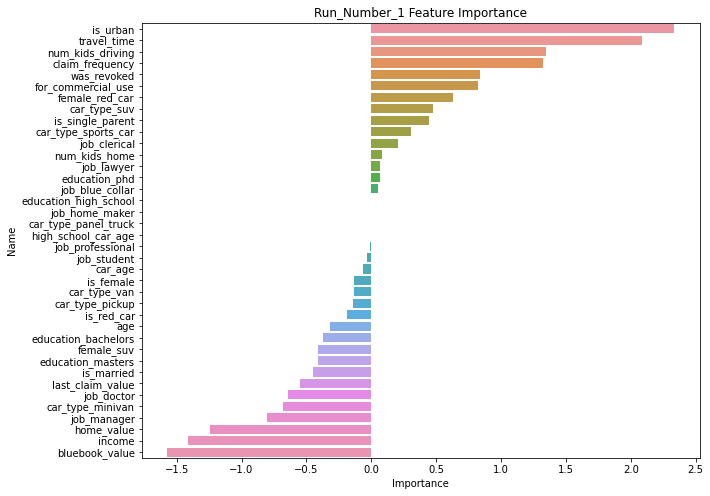

In [13]:
# Instantiate a Modeller object.
run_1: Modeller = Modeller(
    test=test_engineerer.data,
    train=train_engineerer.data,
    config_path="model_configs.yaml",
    entry_point="run_number_1",
)

# Call the Modeller object and store the model's performance.
run_1()
df_all_runs = pd.concat(
    [df_all_runs, run_1.results], axis=0, ignore_index=True
)

# Display the model's results.
run_1.results

##### 3.2 Linear Support Vector Classifier

/Users/rossguthery/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


,run_number,model,metric,train_score
0,2,linear_svc,mean_accuracy,0.786629


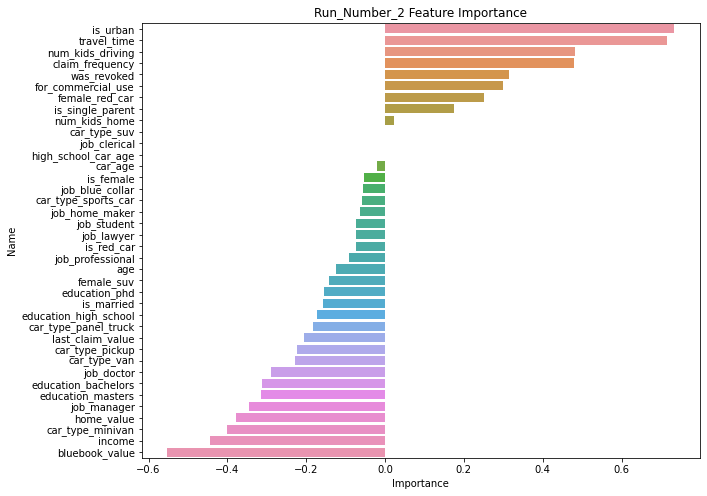

In [14]:
# Instantiate a Modeller object.
run_2: Modeller = Modeller(
    test=test_engineerer.data,
    train=train_engineerer.data,
    config_path="model_configs.yaml",
    entry_point="run_number_2",
)

# Call the Modeller object and store the model's performance.
run_2()
df_all_runs = pd.concat(
    [df_all_runs, run_2.results], axis=0, ignore_index=True
)

# Display the model's results.
run_2.results

In [15]:
# Display performance of all models.
df_all_runs.head()

,run_number,model,metric,train_score
0,1,logistic_regression,mean_accuracy,0.786629
1,2,linear_svc,mean_accuracy,0.786629
